# Processing Sequences using RNNs and CNNs

This chapter looks at fundamental concepts of RNNs and how to train them using backpropagation. Using RNNs to forecast time series

For small sequences, a dense network can work. for long sequences, CNNs can also work very well.

Once the intial theory is read, let's forecast a time series

In [16]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 *  (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

#This creates as many time series as requested by batch_size
#all are univariate, with one value per time step and some noise added in

In [6]:
n_steps = 50

series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [9]:
#Naive forecasting can be our baseline metric. ie. we have to outperform just predicting the last value for all.

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020155853

In [11]:
#so we're trying to beat 0.02 mse, 
#but we can also make a linear regression model which could serve as a more ambitious target

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)    
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0574 - val_loss: 0.0295
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0198 - val_loss: 0.0155
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0044 - val_loss: 0.0046

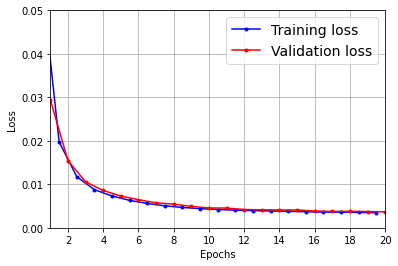

In [17]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [18]:
#So our target should be below 0.0035 in this case
#First try a simple RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.8105 - val_loss: 0.5227
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.3830 - val_loss: 0.2520
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1853 - val_loss: 0.1421
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1463 - val_loss: 0.1524
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1442 - val_loss: 0.1438
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1435 - val_loss: 0.1623
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1423 - val_loss: 0.1269
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0826 - val_loss: 0.0559
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0455 - val_loss: 0.0380
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0336 - val_lo

In [20]:
#Beats the naive forecast but not the linear regression
#probably need more complexity to achieve better results

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 21s 68ms/step - loss: 0.0107 - val_loss: 0.0043
Epoch 2/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 9/20
219/219 [==============================] - 13s 61ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 14s 63ms/step - loss: 0.002

In [21]:
#This RNN beats the linear reg from earlier.
#These so far have only predicted the value of the next immediate time step.
#forecasting several time steps ahead is more difficult.

#options for predicting a number of time steps:
#use the previous model, make it predict the next value, add that value to the inputs
#then use the model to predict the next value, etc

series = generate_time_series(1, n_steps + 10)
X_new, y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 72ms/step


In [22]:
Y_pred.shape

(1, 10, 1)

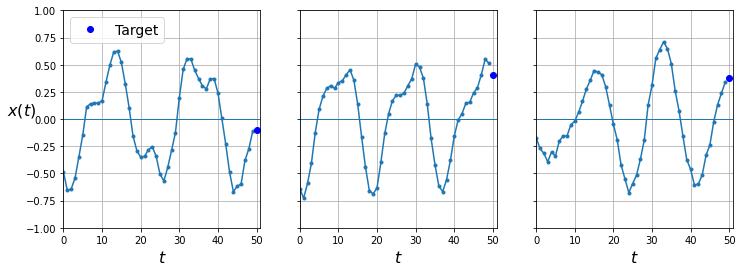

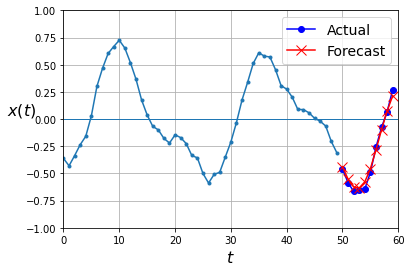

In [26]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

plt.show()

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, y_new, Y_pred)
plt.show()

In [27]:
#The other option for predicting multiple steps:
#train an RNN model to predict all 10 values at once. 
#Using a seq to vec model to output all 10 values at once.

series = generate_time_series(10000, n_steps + 10)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000, :n_steps], series[9000:, -10:, 0]

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [30]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 14s 47ms/step - loss: 0.0541 - val_loss: 0.1197
Epoch 2/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0284 - val_loss: 0.1091
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0198 - val_loss: 0.1151
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0158 - val_loss: 0.1221
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0138 - val_loss: 0.1281
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0126 - val_loss: 0.1340
Epoch 7/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0120 - val_loss: 0.1378
Epoch 8/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0118 - val_loss: 0.1415
Epoch 9/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0109 - val_loss: 0.1463
Epoch 10/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0108 

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 1s 1s/step


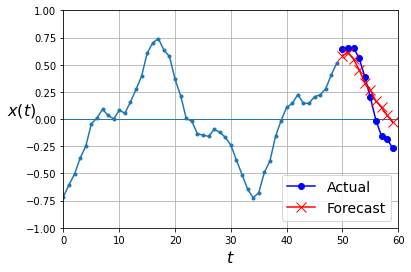

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [37]:
#We can turn this sequence to vector RNN into a seq to seq RNN.
#each target will be a 10d vector

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

#this is a causal model. The model only knows about past time steps.

In [38]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [39]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 14s 47ms/step - loss: 0.0492 - last_time_step_mse: 0.0389 - val_loss: 0.0409 - val_last_time_step_mse: 0.0304
Epoch 2/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0366 - last_time_step_mse: 0.0244 - val_loss: 0.0350 - val_last_time_step_mse: 0.0232
Epoch 3/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0313 - last_time_step_mse: 0.0190 - val_loss: 0.0305 - val_last_time_step_mse: 0.0196
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0283 - last_time_step_mse: 0.0164 - val_loss: 0.0272 - val_last_time_step_mse: 0.0147
Epoch 5/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0257 - last_time_step_mse: 0.0131 - val_loss: 0.0245 - val_last_time_step_mse: 0.0117
Epoch 6/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0244 - last_time_step_mse: 0.0118 - val_loss: 0.0235 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [

In [41]:
#Simple RNNs like this can be good for predicting short sequences. Longer forecasting can be inaccurate.
#an unrolled RNN can be a very deep network, which means it may succumb to the unstable gradients issue.
#good initialization, faster optimizers, dropout can help. but ReLU activation may not help.
#non saturating activation will not help prevent explosion of gradients.
#It is possible we would use some clipping techniques and monitor the gradients using tensorboard.

#Layer Normalization is a new technique which may help alleviate the gradients issue.
#here, create a LN cell from scratch

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                         activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [42]:
#now we can use this cell

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                    input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [43]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 31s 106ms/step - loss: 0.1574 - last_time_step_mse: 0.1393 - val_loss: 0.0686 - val_last_time_step_mse: 0.0587
Epoch 2/20
219/219 [==============================] - 23s 103ms/step - loss: 0.0619 - last_time_step_mse: 0.0525 - val_loss: 0.0592 - val_last_time_step_mse: 0.0487
Epoch 3/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0542 - last_time_step_mse: 0.0432 - val_loss: 0.0518 - val_last_time_step_mse: 0.0409
Epoch 4/20
219/219 [==============================] - 22s 103ms/step - loss: 0.0484 - last_time_step_mse: 0.0368 - val_loss: 0.0456 - val_last_time_step_mse: 0.0326
Epoch 5/20
219/219 [==============================] - 23s 103ms/step - loss: 0.0447 - last_time_step_mse: 0.0321 - val_loss: 0.0446 - val_last_time_step_mse: 0.0331
Epoch 6/20
219/219 [==============================] - 23s 103ms/step - loss: 0.0423 - last_time_step_mse: 0.0297 - val_loss: 0.0402 - val_last_time_step_mse: 0.0269
Epoch 7/20

In [44]:
#When traversing an RNN, information is lost at each step. In order to prevent this, longer term memory cells are used.
#Take a look at LSTM
#It will converge faster and perform better than the SimpleRNN cell 

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [45]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 34s 105ms/step - loss: 0.0767 - last_time_step_mse: 0.0610 - val_loss: 0.0527 - val_last_time_step_mse: 0.0290
Epoch 2/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0462 - last_time_step_mse: 0.0232 - val_loss: 0.0419 - val_last_time_step_mse: 0.0177
Epoch 3/20
219/219 [==============================] - 21s 97ms/step - loss: 0.0386 - last_time_step_mse: 0.0164 - val_loss: 0.0369 - val_last_time_step_mse: 0.0140
Epoch 4/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0342 - last_time_step_mse: 0.0134 - val_loss: 0.0333 - val_last_time_step_mse: 0.0121
Epoch 5/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0318 - last_time_step_mse: 0.0126 - val_loss: 0.0314 - val_last_time_step_mse: 0.0124
Epoch 6/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0304 - last_time_step_mse: 0.0120 - val_loss: 0.0301 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/

In [46]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 2s 24ms/step - loss: 0.0237 - last_time_step_mse: 0.0086


[0.023749062791466713, 0.00859263725578785]

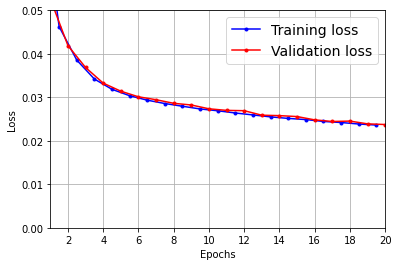

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 2s 2s/step


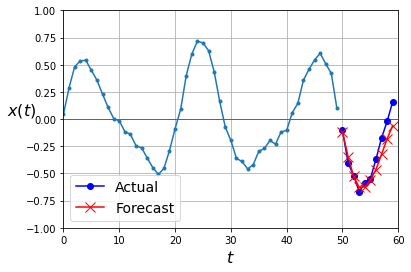

In [48]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [50]:
#GRU cell perform as well as LSTM, but are simpler.
#GRU and LSTM still have difficulty performing in sequences of 100 or more time steps.
#Shortening the input sequences using 1d conv layers can help.

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid',
                       input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                   validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 15s 42ms/step - loss: 0.0711 - last_time_step_mse: 0.0638 - val_loss: 0.0469 - val_last_time_step_mse: 0.0397
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0385 - last_time_step_mse: 0.0313 - val_loss: 0.0357 - val_last_time_step_mse: 0.0289
Epoch 3/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0319 - last_time_step_mse: 0.0235 - val_loss: 0.0308 - val_last_time_step_mse: 0.0208
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0280 - last_time_step_mse: 0.0180 - val_loss: 0.0270 - val_last_time_step_mse: 0.0158
Epoch 5/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0255 - last_time_step_mse: 0.0146 - val_loss: 0.0249 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0239 - last_time_step_mse: 0.0128 - val_loss: 0.0237 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/219 [=

In [52]:
#As a final example, we will compile a WaveNet model. In WaveNet, early layers learn short term patterns
#higher layers learn longer term patterns

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal',
                                 activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                   validation_data=(X_valid, Y_valid))
    

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.0684 - last_time_step_mse: 0.0563 - val_loss: 0.0356 - val_last_time_step_mse: 0.0212
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0321 - last_time_step_mse: 0.0186 - val_loss: 0.0301 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0287 - last_time_step_mse: 0.0157 - val_loss: 0.0279 - val_last_time_step_mse: 0.0148
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0270 - last_time_step_mse: 0.0143 - val_loss: 0.0268 - val_last_time_step_mse: 0.0138
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0259 - last_time_step_mse: 0.0133 - val_loss: 0.0258 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0251 - last_time_step_mse: 0.0126 - val_loss: 0.0248 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219 [==